# **Corona Virus-related Tweeets Analytics**

This notebook is dedicated to loading and analizing the data in CoronaVirus tweets dataset maintained in IEEE (see the links below).

In order to run this notebook, you should complete the pre-requisites below

- in your Google Drive, create a folder 'CoronaTweets'

**Note**: The IEEE-backed tweets data stored in corona_tweets bucket in GCP

In [0]:
!pip install pdpipe pydata-google-auth wordcloud

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for decore: filename=decore-0.0.1-py2.py3-none-any.whl size=4190 sha256=93a61a7c55997ec85936757141d0edf013ab8f1765e6a41603f8655b7a78c275
  Stored in directory: /root/.cache/pip/wheels/6c/1b/9c/71fa8b5df01cc605c4b5cadcd81df76d520149ca5c02b4013b
Successfully built decore


In [0]:
import pandas as pd
import pdpipe as pdp
import datetime as dt
import sqlite3
import pydata_google_auth

from google.colab import drive
from google.colab import auth

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

stemmer = SnowballStemmer('english')
stop_words = stopwords.words('english')

# problem-specific tokens to exclude
filter_out_from_tweets = [
    'rt',
    'http',
    'https',
    'corona',
    'coronavirus',
    'virus',
    'covid',
    'sars'
]

def drop_tweeet_user_name(tweet_text):
  tweet = re.sub('@[^\s]+','', tweet_text)
  return tweet


def clean_text(original_string):
  return re.sub(r'[^a-zA-Z ]', '', original_string)

def wordfilter(original_string):
    filtered = []
    to_eliminate = stop_words + filter_out_from_tweets
    tokens = word_tokenize(original_string)
    for word in tokens:
      if word not in to_eliminate:
        filtered.append(stemmer.stem(word))
    
    result = " ".join(filtered)
    return result


def is_positive(sentiment_score):
    if sentiment_score > 0:
        return 1
    else:
        return 0


def is_negative(sentiment_score):
    if sentiment_score < 0:
        return 1
    else:
        return 0


def is_neutral(sentiment_score):
    if sentiment_score == 0:
        return 1
    else:
        return 0

# This will mount the drive to this notebook
drive.mount('/content/drive')

# This will connect to your project and list all buckets 
auth.authenticate_user()
project_id = 'fcg-bi-prod'
!gcloud config set project {project_id}
!gsutil ls

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Updated property [core/project].
gs://corona_tweets/
gs://europe-west1-bach-2a178df1-bucket/
gs://europe-west1-bach-75b05860-bucket/
gs://fcg-bi-prod.appspot.com/
gs://fcg_dataflow_prod/
gs://logzio-sync-backend/
gs://logzio-sync-frontend/
gs://logzio-sync-prism/
gs://mixpanel_events_prod/
gs://nodeping/
gs://staging.fcg-bi-prod.appspot.com/


In [0]:
# this will copy data from the bucket with corona tweets to 
# the personal Google drive ('My Drive/CoronaTweets/' subfolder, namely)
#
# Note: !gsutil -m cp -r gs://{bucket_name}/* /content/drive/My\ Drive/CoronaTweets/
#       runs faster (vs. the command without -m switch) 
#       but the process halts for some time for a weird reason 
#       (as some threads do not return its completion state timely?) - 
#       so you should be patient to wait for it to complete correctly
bucket_name = 'corona_tweets'
!gsutil -m cp -r gs://{bucket_name}/* /content/drive/My\ Drive/CoronaTweets/

Copying gs://corona_tweets/corona_tweets_1M/tweets.db...
Copying gs://corona_tweets/corona_tweets_1M_2/tweets.db...
Copying gs://corona_tweets/corona_tweets_2L/tweets.db...
Copying gs://corona_tweets/corona_tweets_3M/tweets.db...
Copying gs://corona_tweets/corona_tweets_2M_3/tweets.db...
| [5/5 files][  4.0 GiB/  4.0 GiB] 100% Done  35.9 MiB/s ETA 00:00:00           
Operation completed over 5 objects/4.0 GiB.                                      


In [0]:
base_db_folder = '/content/drive/My Drive/CoronaTweets'
tweet_db_paths = [
    # incomplete data - '/corona_tweets_1M.db/corona_tweets_1M.db',   # 27.02.2020 10:36 01.03.2020 18:24 1578957
    # malformed - '/corona_tweets_2M_2/corona_tweets_2M_2.db',  # 02.03.2020 17:27	07.03.2020 4:57	2268665
    '/corona_tweets_3M/tweets.db',  # 07.03.2020 5:06	14.03.2020 4:46	7472368
    '/corona_tweets_1M/tweets.db',  # 14.03.2020 5:23	15.03.2020 3:16	1903768
    '/corona_tweets_2M_3/tweets.db',  # 15.03.2020 3:28	16.03.2020 4:31	2081576
    '/corona_tweets_1M_2/tweets.db',  # 16.03.2020 4:38	17.03.2020 3:08	1889781
    '/corona_tweets_2L/tweets.db'  # 17.03.2020 3:12	17.03.2020 6:10	280304
]

pipeline = pdp.PdPipeline([
    pdp.ColRename({'unix': 'tweet_date'}),
    pdp.ApplyByCols('sentiment', is_positive, 'is_positive', drop=False),
    pdp.ApplyByCols('sentiment', is_negative, 'is_negative', drop=False),
    pdp.ApplyByCols('sentiment', is_neutral, 'is_neutral', drop=False),
])

tweets_df = pd.DataFrame()

for tweets_db in tweet_db_paths:
    full_tweet_db_path = base_db_folder + tweets_db
    print(dt.datetime.now(), "Processing started: ", full_tweet_db_path)
    conn = sqlite3.connect(full_tweet_db_path)
    c = conn.cursor()
    df_pie = pd.read_sql("SELECT * FROM sentiment", conn)
    df_pie['unix'] = pd.to_datetime(df_pie['unix'], unit='ms').dt.date  # cast to date
    df = pipeline.apply(df_pie).sort_values(by=['tweet_date'])

    if df.shape[0] < 1:
        tweets_df = df
    else:
        # concatenate
        frames = [tweets_df, df]
        tweets_df = pd.concat(frames)

    print(":: Processed fully: ", full_tweet_db_path)

2020-03-28 17:27:07.575776 Processing started:  /content/drive/My Drive/CoronaTweets/corona_tweets_3M/tweets.db
:: Processed fully:  /content/drive/My Drive/CoronaTweets/corona_tweets_3M/tweets.db
2020-03-28 17:28:44.994872 Processing started:  /content/drive/My Drive/CoronaTweets/corona_tweets_1M/tweets.db
:: Processed fully:  /content/drive/My Drive/CoronaTweets/corona_tweets_1M/tweets.db
2020-03-28 17:29:14.932025 Processing started:  /content/drive/My Drive/CoronaTweets/corona_tweets_2M_3/tweets.db
:: Processed fully:  /content/drive/My Drive/CoronaTweets/corona_tweets_2M_3/tweets.db
2020-03-28 17:29:40.652802 Processing started:  /content/drive/My Drive/CoronaTweets/corona_tweets_1M_2/tweets.db
:: Processed fully:  /content/drive/My Drive/CoronaTweets/corona_tweets_1M_2/tweets.db
2020-03-28 17:30:10.745420 Processing started:  /content/drive/My Drive/CoronaTweets/corona_tweets_2L/tweets.db
:: Processed fully:  /content/drive/My Drive/CoronaTweets/corona_tweets_2L/tweets.db


In [0]:
# aggregate the summary statistics
df_positives = tweets_df.groupby(['tweet_date'])['is_positive'].sum().reset_index()
df_negatives = tweets_df.groupby(['tweet_date'])['is_negative'].sum().reset_index()
df_neutrals = tweets_df.groupby(['tweet_date'])['is_neutral'].sum().reset_index()

tweets_summary_df = pd.merge(
    pd.merge(df_positives, df_negatives, on=['tweet_date']),
    df_neutrals, on=['tweet_date'])

print('---- Tweet summary info: ----')
print(tweets_summary_df.info())
print('---- Head: ----')
print(tweets_summary_df.head())
print('---- Tail: ----')
print(tweets_summary_df.tail())

---- Tweet summary info: ----
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 4 columns):
tweet_date     11 non-null object
is_positive    11 non-null int64
is_negative    11 non-null int64
is_neutral     11 non-null int64
dtypes: int64(3), object(1)
memory usage: 440.0+ bytes
None
---- Head: ----
   tweet_date  is_positive  is_negative  is_neutral
0  2020-03-07        91312        77850      110236
1  2020-03-08       118730       135332      206954
2  2020-03-09       246976       123657      238528
3  2020-03-10       285013       180410      334318
4  2020-03-11       293844       210470      582301
---- Tail: ----
    tweet_date  is_positive  is_negative  is_neutral
6   2020-03-13       607452       476973      807144
7   2020-03-14       644937       356931     1027619
8   2020-03-15       684067       443435      842187
9   2020-03-16       698550       416820      896678
10  2020-03-17       148666       113855      285591


In [0]:
# WRITE TO BQ

# tweets_summary_df.to_gbq('covid19_tracking.covid19_tweets', project_id='fcg-bi-prod', if_exists='replace')

1it [00:05,  5.41s/it]


In [0]:
# pulling the stats from WHO / JHO Univ on COVID-19 (confirmed cases, deaths, recovered cases)

# fetching the latest time series data sets
confirmed_ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths_ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
recovered_ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

confirmed_ts_melted_df = confirmed_ts_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long',],
                     var_name='covid_date', value_name='confirmed').copy()

deaths_ts_melted_df = deaths_ts_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long',],
                     var_name='covid_date', value_name='deaths').copy()

recovered_ts_melted_df = recovered_ts_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long',],
                     var_name='covid_date', value_name='recovered').copy()

pipeline = pdp.PdPipeline([
    pdp.ApplyByCols(['covid_date'], pd.to_datetime),
    pdp.ColRename({'Country/Region': 'country_id', 'Province/State': 'state', 'Lat': 'lat', 'Long': 'long'})

])

confirmed_ts_fcg_df = pipeline.apply(confirmed_ts_melted_df).sort_values(by=['country_id', 'covid_date'])
deaths_ts_fcg_df = pipeline.apply(deaths_ts_melted_df).sort_values(by=['country_id', 'covid_date'])
recovered_ts_fcg_df = pipeline.apply(recovered_ts_melted_df).sort_values(by=['country_id', 'covid_date'])

covid_df = pd.merge(
    pd.merge(confirmed_ts_fcg_df, deaths_ts_fcg_df, on=['state', 'country_id', 'lat', 'long','covid_date']),
    recovered_ts_fcg_df, on=['state', 'country_id', 'lat', 'long','covid_date'])

covid_df.head()

,state,country_id,lat,long,covid_date,confirmed,deaths,recovered
0,NaN,Afghanistan,33.0,65.0,2020-01-22,0,0,0
1,NaN,Afghanistan,33.0,65.0,2020-01-23,0,0,0
2,NaN,Afghanistan,33.0,65.0,2020-01-24,0,0,0
3,NaN,Afghanistan,33.0,65.0,2020-01-25,0,0,0
4,NaN,Afghanistan,33.0,65.0,2020-01-26,0,0,0


In [0]:
# get summary COVID-19 statistics across the globe (we need on the global scale, to match with the tweet stat numerals)

df_confirmed = covid_df.groupby(['covid_date'])['confirmed'].sum().reset_index()
df_deaths = covid_df.groupby(['covid_date'])['deaths'].sum().reset_index()
df_recovered = covid_df.groupby(['covid_date'])['recovered'].sum().reset_index()

covid_summary_df = pd.merge(
    pd.merge(df_confirmed, df_deaths, on=['covid_date']),
    df_recovered, on=['covid_date'])


In [0]:
# merge the COVID-19 core metrics and CoronaVirus Tweet Charts
dates_with_tweet_stats = [
      '2020-03-07',
      '2020-03-08',
      '2020-03-09', 
      '2020-03-10', 
      '2020-03-11',  
      '2020-03-12',
      '2020-03-13', 
      '2020-03-14',
      '2020-03-15',
      '2020-03-16',
      # '2020-03-17'   
]


pipeline = pdp.PdPipeline([
    pdp.ApplyByCols(['covid_date'], pd.to_datetime),
    pdp.ColRename({'covid_date': 'tweet_date'}),
    pdp.ValKeep(dates_with_tweet_stats, columns=['tweet_date']),
])

covid_summary_df = pipeline.apply(covid_summary_df).sort_values(by=['tweet_date'])

In [0]:
covid_summary_df['tweet_date'] = pd.to_datetime(covid_summary_df['tweet_date']).dt.date

covid_summary_df = pd.merge(covid_summary_df, tweets_summary_df, on=['tweet_date'])

covid_summary_df.head()

,tweet_date,confirmed,deaths,recovered,is_positive,is_negative,is_neutral
0,2020-03-07,105793,3558,58350,91312,77850,110236
1,2020-03-08,109757,3802,60686,118730,135332,206954
2,2020-03-09,113513,3987,62486,246976,123657,238528
3,2020-03-10,118541,4261,64396,285013,180410,334318
4,2020-03-11,125767,4614,66995,293844,210470,582301


In [0]:
px.line(covid_summary_df, x='tweet_date', y='is_positive', title='Positive tweets on COVID-19: Global Evolution')

In [0]:
px.line(covid_summary_df, x='tweet_date', y='is_negative', title='Negative tweets on COVID-19: Global Evolution')

In [0]:
px.line(covid_summary_df, x='tweet_date', y='is_neutral', title='Neutral tweets on COVID-19: Global Evolution')

In [0]:
# History of CoronaVirus-related tweets globally: Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=covid_summary_df['tweet_date'], y=covid_summary_df['is_neutral'],
                    mode='lines+markers',
                    name='Neutral'))
fig.add_trace(go.Scatter(x=covid_summary_df['tweet_date'], y=covid_summary_df['is_positive'],
                    mode='lines+markers',
                    name='Positive'))
fig.add_trace(go.Scatter(x=covid_summary_df['tweet_date'], y=covid_summary_df['is_negative'],
                    mode='lines+markers', 
                    name='Negative'))
# Edit the layout
fig.update_layout(title='History of CoronaVirus-related tweets globally (Mar 7-16, 2020)',
                   xaxis_title='Date',
                   yaxis_title='Number of tweets')
fig.show()

In [0]:
# additional ratio features
pipe_calc = pdp.PdPipeline([
    pdp.ApplyToRows(lambda row: (row['deaths']/row['confirmed']), 'dead_to_confirmed'),
    pdp.ApplyToRows(lambda row: (row['recovered']/row['confirmed']), 'recovered_to_confirmed'),
    pdp.ApplyToRows(lambda row: (row['is_positive']/(row['is_positive'] + row['is_negative'] + row['is_neutral'])), 'pos_ratio'),
    pdp.ApplyToRows(lambda row: (row['is_negative']/(row['is_positive'] + row['is_negative'] + row['is_neutral'])), 'neg_ratio'),
    pdp.ApplyToRows(lambda row: (row['is_neutral']/(row['is_positive'] + row['is_negative'] + row['is_neutral'])), 'neu_ratio'),                  
])

# calculate ratio attributes
covid_summary_df = pipe_calc.apply(covid_summary_df)
display(covid_summary_df)

,tweet_date,confirmed,deaths,recovered,is_positive,is_negative,is_neutral,dead_to_confirmed,recovered_to_confirmed,pos_ratio,neg_ratio,neu_ratio
0,2020-03-07,105793,3558,58350,91312,77850,110236,0.033632,0.551549,0.326817,0.278635,0.394548
1,2020-03-08,109757,3802,60686,118730,135332,206954,0.034640,0.552912,0.257540,0.293552,0.448908
2,2020-03-09,113513,3987,62486,246976,123657,238528,0.035124,0.550474,0.405436,0.202996,0.391568
3,2020-03-10,118541,4261,64396,285013,180410,334318,0.035945,0.543238,0.356382,0.225586,0.418033
4,2020-03-11,125767,4614,66995,293844,210470,582301,0.036687,0.532691,0.270421,0.193693,0.535885
5,2020-03-12,128235,4719,68316,693063,372475,875423,0.036800,0.532741,0.357072,0.191902,0.451026
6,2020-03-13,145012,5403,70243,607452,476973,807144,0.037259,0.484394,0.321137,0.252157,0.426706
7,2020-03-14,155903,5818,72616,644937,356931,1027619,0.037318,0.465777,0.317783,0.175873,0.506344
8,2020-03-15,167202,6439,76026,684067,443435,842187,0.038510,0.454696,0.347297,0.225129,0.427574
9,2020-03-16,181159,7122,78079,698550,416820,896678,0.039314,0.430997,0.347184,0.207162,0.445654


## Dead-to-Confirmed Cases Ratio vs. Positive Tweets Ratio

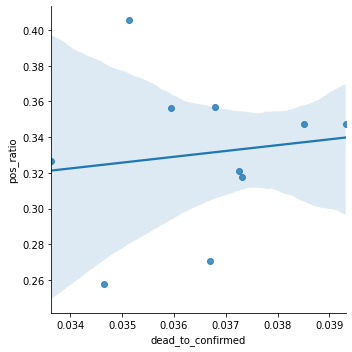

In [0]:
# Plot using Seaborn
ax = sns.lmplot(x='dead_to_confirmed', y='pos_ratio', data=covid_summary_df,
           fit_reg=True)
ax

As we can see, it looks like there is no any strong relation between the ratio of the positive tweets toward Corona and the actual cumulative dead-to-confirmed ratio.

## Dead-to-Confirmed Cases Ratio vs. Positive Tweets Ratio

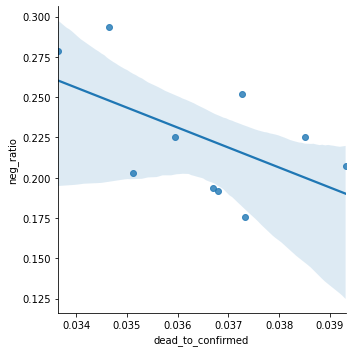

In [0]:
ax = sns.lmplot(x='dead_to_confirmed', y='neg_ratio', data=covid_summary_df,
           fit_reg=True)
ax

As we can see, there might be a mediumm-to-strong relation between the ratio of the negative tweets toward Corona and the actual cumulative dead-to-confirmed ratio.

# Positive vs. Negative Tweets Ratio

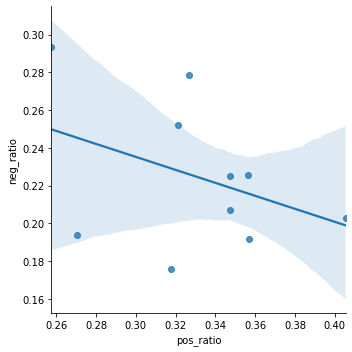

In [0]:
ax = sns.lmplot(x='pos_ratio', y='neg_ratio', data=covid_summary_df,
           fit_reg=True)
ax

In [0]:
# Negative tweets: negative tweets, Mar 16, 2020

pipeline = pdp.PdPipeline([
    pdp.ValKeep([1], columns=['is_negative']),
    pdp.ValKeep([dt.date(2020,3,16)], columns=['tweet_date']),
])

neg_tweets_df = pipeline.apply(tweets_df).sort_values(by=['tweet_date'])
# neg_tweets_df = neg_tweets_df[neg_tweets_df['tweet_date'] == dt.date(2020,3,16) ]  
neg_tweets_df.head()

,tweet_date,tweet,sentiment,is_neutral,is_negative,is_positive
1951550,2020-03-16,RT @nicoleshampoo: The corona isn't scaring me...,-0.600000,0,1,0
226213,2020-03-16,RT @megturney: What the actual fuck.,-0.200000,0,1,0
226220,2020-03-16,RT @Whytrustme: The west really ain't shit LOO...,-0.233333,0,1,0
226284,2020-03-16,RT @Iowlifee: This corona shit getting serious...,-0.233333,0,1,0
226283,2020-03-16,jungkook black swan fancam bts 18+ ifb comebac...,-0.166667,0,1,0


## WordCloud: Negative Tweets, Mar 16, 2020

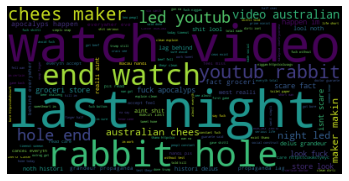

In [0]:
# Word cloud: negative tweets, Mar 16, 2020

# convert cleaned tweet texts to lower case
neg_tweets_df['tweet'] = neg_tweets_df['tweet'].str.lower()

pipeline = pdp.PdPipeline([
    pdp.ColDrop(['sentiment',	'is_neutral',	'is_negative',	'is_positive']),
    pdp.ApplyByCols('tweet', drop_tweeet_user_name),
    pdp.ApplyByCols('tweet', clean_text),
    pdp.ApplyByCols('tweet', wordfilter)
])

neg_tweets_df = pipeline.apply(neg_tweets_df)

text_base = ' '.join(neg_tweets_df['tweet'].tolist())
wordcloud = WordCloud().generate(text_base)
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

In [0]:
# Positive tweets: Mar 16, 2020

pipeline = pdp.PdPipeline([
    pdp.ValKeep([1], columns=['is_positive']),
    pdp.ValKeep([dt.date(2020,3,16)], columns=['tweet_date'])
])

pos_tweets_df = pipeline.apply(tweets_df).sort_values(by=['tweet_date'])
# pos_tweets_df = pos_tweets_df[pos_tweets_df['tweet_date'] == dt.date(2020,3,16) ]  
pos_tweets_df.head()

,tweet_date,tweet,sentiment,is_neutral,is_negative,is_positive
1951554,2020-03-16,RT @faceyourfront: 8 days into Corona and this...,0.300000,0,0,1
354377,2020-03-16,RT @narendramodi: Doing our best to ensure eve...,0.500000,0,0,1
354376,2020-03-16,RT @GermanAmbGhana: Ghanaian Government has ju...,0.500000,0,0,1
354374,2020-03-16,RT @umarsaif: Most people who get Corona infec...,0.400000,0,0,1
354371,2020-03-16,RT @ManaByte: Thanos was right.,0.285714,0,0,1


## WordCloud: Positive Tweets, Mar 16, 2020

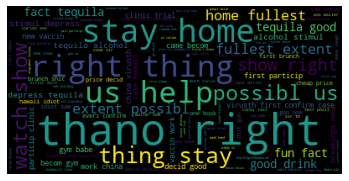

In [0]:
# Word cloud: positive tweets, Mar 16, 2020

# convert cleaned tweet texts to lower case
pos_tweets_df['tweet'] = pos_tweets_df['tweet'].str.lower()

pipeline = pdp.PdPipeline([
    pdp.ColDrop(['sentiment',	'is_neutral',	'is_negative',	'is_positive']),
    pdp.ApplyByCols('tweet', drop_tweeet_user_name),
    pdp.ApplyByCols('tweet', clean_text),
    pdp.ApplyByCols('tweet', wordfilter)
])

pos_tweets_df = pipeline.apply(pos_tweets_df)

text_base = ' '.join(pos_tweets_df['tweet'].tolist())
wordcloud = WordCloud().generate(text_base)
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

## WordCloud: Negative Tweets, Mar 15, 2020

In [0]:
# Negative tweets: negative tweets, Mar 15, 2020

pipeline = pdp.PdPipeline([
    pdp.ValKeep([1], columns=['is_negative']),
    pdp.ValKeep([dt.date(2020,3,15)], columns=['tweet_date']),
])

neg_tweets_df = pipeline.apply(tweets_df).sort_values(by=['tweet_date']) 
neg_tweets_df.head()

,tweet_date,tweet,sentiment,is_neutral,is_negative,is_positive
1811036,2020-03-15,RT @bIondiewasabi: it's crazy how because of c...,-0.188889,0,1,0
355526,2020-03-15,RT @oatmilkstanacct: corona virus:\n-boring\n-...,-0.462500,0,1,0
355532,2020-03-15,RT @MrDre_: If I gave you 100 skittles and tol...,-0.050000,0,1,0
355392,2020-03-15,RT @svnchine: MACAU has now ZERO CASE of Coron...,-0.100000,0,1,0
355382,2020-03-15,"RT @First_alphas: ""God wants to use Corona vir...",-0.266667,0,1,0


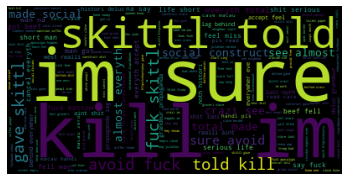

In [0]:
# Word cloud: negative tweets, Mar 15, 2020

# convert cleaned tweet texts to lower case
neg_tweets_df['tweet'] = neg_tweets_df['tweet'].str.lower()

pipeline = pdp.PdPipeline([
    pdp.ColDrop(['sentiment',	'is_neutral',	'is_negative',	'is_positive']),
    pdp.ApplyByCols('tweet', drop_tweeet_user_name),
    pdp.ApplyByCols('tweet', clean_text),
    pdp.ApplyByCols('tweet', wordfilter)
])

neg_tweets_df = pipeline.apply(neg_tweets_df)

text_base = ' '.join(neg_tweets_df['tweet'].tolist())
wordcloud = WordCloud().generate(text_base)
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

## WordCloud: Positive Tweets, Mar 15, 2020

In [0]:
# Positive tweets: Mar 15, 2020

pipeline = pdp.PdPipeline([
    pdp.ValKeep([1], columns=['is_positive']),
    pdp.ValKeep([dt.date(2020,3,15)], columns=['tweet_date'])
])

pos_tweets_df = pipeline.apply(tweets_df).sort_values(by=['tweet_date']) 
pos_tweets_df.head()

,tweet_date,tweet,sentiment,is_neutral,is_negative,is_positive
1811034,2020-03-15,Even better visual... Stay. Home.\n\nWhy outbr...,0.250000,0,0,1
409200,2020-03-15,RT @_Tinushka_: Here's some advice from an Arm...,0.333333,0,0,1
409198,2020-03-15,Finding love in a hopeless place. :),0.500000,0,0,1
409220,2020-03-15,RT @Qnet28: Always looks good in whatever u we...,0.600000,0,0,1
409221,2020-03-15,Poor you! Have some cute pets plus cute babies...,0.166667,0,0,1


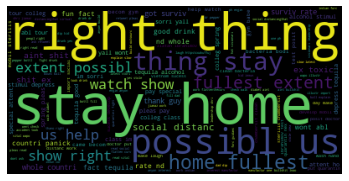

In [0]:
# Word cloud: positive tweets, Mar 15, 2020

# convert cleaned tweet texts to lower case
pos_tweets_df['tweet'] = pos_tweets_df['tweet'].str.lower()

pipeline = pdp.PdPipeline([
    pdp.ColDrop(['sentiment',	'is_neutral',	'is_negative',	'is_positive']),
    pdp.ApplyByCols('tweet', drop_tweeet_user_name),
    pdp.ApplyByCols('tweet', clean_text),
    pdp.ApplyByCols('tweet', wordfilter)
])

pos_tweets_df = pipeline.apply(pos_tweets_df)

text_base = ' '.join(pos_tweets_df['tweet'].tolist())
wordcloud = WordCloud().generate(text_base)
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

# References

- Build pipelines with Pandas using “pdpipe” (https://towardsdatascience.com/https-medium-com-tirthajyoti-build-pipelines-with-pandas-using-pdpipe-cade6128cd31)
- Transferring data between Google Drive and Google Cloud Storage using Google Colab (https://medium.com/@philipplies/transferring-data-from-google-drive-to-google-cloud-storage-using-google-colab-96e088a8c041)
- CoronaVirus Tweets DataSet Home (https://ieee-dataport.org/open-access/corona-virus-covid-19-tweets-dataset) - it had been shared under GNU license; however, as of Mar 20, 2020 morning CET, the public access to this dataset has been closed by the dataset mainteiner ( by Rabindra Lamsal at Database Systems and Artificial Intelligence Lab)
- https://sentiment.live/ - the live feed that produces the dataset above 